In [41]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Classifying crisis periods

Using classification of bear market from [Hartford Funds (Ned Devis Research)](https://www.hartfordfunds.com/dam/en/docs/pub/whitepapers/CCWP045.pdf)

In [2]:
# Reading table present on the file

bear_markets = pd.read_csv("./data/bear_market.csv")
bear_markets = bear_markets.drop(columns=['return_percentage','days_duration'])

type_mapping = {
    'start': 'datetime64[ns]',
    'end': 'datetime64[ns]'
}

bear_markets = bear_markets.astype(type_mapping)
bear_markets.head(5)

,start,end
0,1929-09-07,1929-11-13
1,1930-04-10,1930-12-16
2,1931-02-24,1931-06-02
3,1931-06-27,1931-10-05
4,1931-11-09,1932-06-01


In [3]:
# Functions to calculate semester start and end

def get_semester_start(date: 'datetime[64]'):
    '''
    Creates the date that semester starts.

    Args:
        start date (datetime): start date of bear market

    Returns:
        datetime.date: A date object representing the start of the semester.
    '''
    
    if date.month <= 6:
        return pd.Timestamp(year=date.year, month=1, day=1)
    else:
        return pd.Timestamp(year=date.year, month=7, day=1)

def get_semester_end(date: 'datetime[64]'):
    '''
    Creates the date that semester emds.

    Args:
        end date (datetime): end date of bear market

    Returns:
        datetime.date: A date object representing the end of the semester.
    '''
    
    if date.month <= 6:
        return pd.Timestamp(year=date.year, month=1, day=1)
    else:
        return pd.Timestamp(year=date.year, month=7, day=1)

# Apply the function to create new columns
bear_markets['start-sm-dt'] = bear_markets['start'].apply(get_semester_start)
bear_markets['end-sm-dt'] = bear_markets['end'].apply(get_semester_end)
bear_markets.head(5)

,start,end,start-sm-dt,end-sm-dt
0,1929-09-07,1929-11-13,1929-07-01,1929-07-01
1,1930-04-10,1930-12-16,1930-01-01,1930-07-01
2,1931-02-24,1931-06-02,1931-01-01,1931-01-01
3,1931-06-27,1931-10-05,1931-01-01,1931-07-01
4,1931-11-09,1932-06-01,1931-07-01,1932-01-01


In [4]:
def classify_semesters(bear_markets_df):
    '''
    Expands bear market classification to all semesters in the data range.

    Args:
        bear_market (dataframe): listing dates of start and date

    Returns:
        semester classification: a dataframe with all semester classified by Market Type.
    '''
    
    # Ensure datetime
    bear_markets['start'] = pd.to_datetime(bear_markets['start'])
    bear_markets['end'] = pd.to_datetime(bear_markets['end'])
    
    # Define semester range (starting from first bear market start)
    first_date = bear_markets['start'].min()
    last_date = bear_markets['end'].max()

    # Create semesters every 6 months
    semesters = pd.date_range(
        start=pd.Timestamp(year=first_date.year, month=1 if first_date.month <= 6 else 7, day=1),
        end=pd.Timestamp(year=last_date.year, month=7 if last_date.month <= 6 else 1, day=1) + pd.offsets.MonthEnd(6),
        freq='6MS'
    )

    # Create DataFrame of semesters
    semester_df = pd.DataFrame({
        'semester_start': semesters,
        'semester_end': semesters + pd.DateOffset(months=6) - pd.Timedelta(days=1)
    })

    # Function to check if a semester overlaps with any bear market
    def is_bear(row):
        for _, bear in bear_markets.iterrows():
            latest_start = max(row['semester_start'], bear['start'])
            earliest_end = min(row['semester_end'], bear['end'])
            if (earliest_end - latest_start).days >= 0:
                return 'Bear Market'
        return 'Normal Market'
    
    # Apply classification
    semester_df['Market Type'] = semester_df.apply(is_bear, axis=1)
    
    return semester_df

semester_classification = classify_semesters(bear_markets)

semester_classification

,semester_start,semester_end,Market Type
0,1929-07-01,1929-12-31,Bear Market
1,1930-01-01,1930-06-30,Bear Market
2,1930-07-01,1930-12-31,Bear Market
3,1931-01-01,1931-06-30,Bear Market
4,1931-07-01,1931-12-31,Bear Market
...,...,...,...
181,2020-01-01,2020-06-30,Bear Market
182,2020-07-01,2020-12-31,Normal Market
183,2021-01-01,2021-06-30,Normal Market
184,2021-07-01,2021-12-31,Normal Market


# 2. Getting returns from pairs trading

Using returns from distance methods, based in output from [bkalil7/tcc](https://github.com/bkalil7/tcc).

In [18]:
filePath = "./data/operations.csv"

startDate = "1990-01-01"
endDate = "2015-01-01"

def loadData(filePath):
    data = pd.read_csv(filePath)
    return data

#Retorna os dados de acordo com o arquivo e com o resultado semestral consolidado
def processDataReturns(data):
    dataReturns = data['Return']
    dataReturns = dataReturns.astype(float).to_frame()
    dataReturnsBySemester = data.groupby('Semester')['Return'].prod().to_frame()

    print(type(dataReturns))
    print(type(dataReturnsBySemester))
    return dataReturns, dataReturnsBySemester

#Transforma os dados ordenados por index em date para cada semestre
def assignDatesToReturns(dataReturnsBySemester, startDate):
    dates = pd.date_range(start=startDate, periods=len(dataReturnsBySemester), freq='2QS')
    dataReturnsBySemester.index = dates
    return dataReturnsBySemester

In [19]:
data = loadData(filePath)

In [30]:
#Carrega os retornos dos dados em formato semestral

dataReturns, dataReturnsBySemester = processDataReturns(data)
dataReturnsBySemester = assignDatesToReturns(dataReturnsBySemester, startDate)

dataReturnsBySemester = dataReturnsBySemester.reset_index(names='semester_start')
dataReturnsBySemester.head(5)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,semester_start,Return
0,1990-01-01,2.096078
1,1990-07-01,1.583414
2,1991-01-01,2.642023
3,1991-07-01,1.692929
4,1992-01-01,0.815386


In [34]:
# Criar dataframe único do semestre com retorno e classificação do semestre 

return_by_market = pd.merge(
    left = dataReturnsBySemester,
    right = semester_classification,
    left_on = 'semester_start',
    right_on = 'semester_start',
    how = 'left'
)

return_by_market.head()

,semester_start,Return,semester_end,Market Type
0,1990-01-01,2.096078,1990-06-30,Normal Market
1,1990-07-01,1.583414,1990-12-31,Normal Market
2,1991-01-01,2.642023,1991-06-30,Normal Market
3,1991-07-01,1.692929,1991-12-31,Normal Market
4,1992-01-01,0.815386,1992-06-30,Normal Market


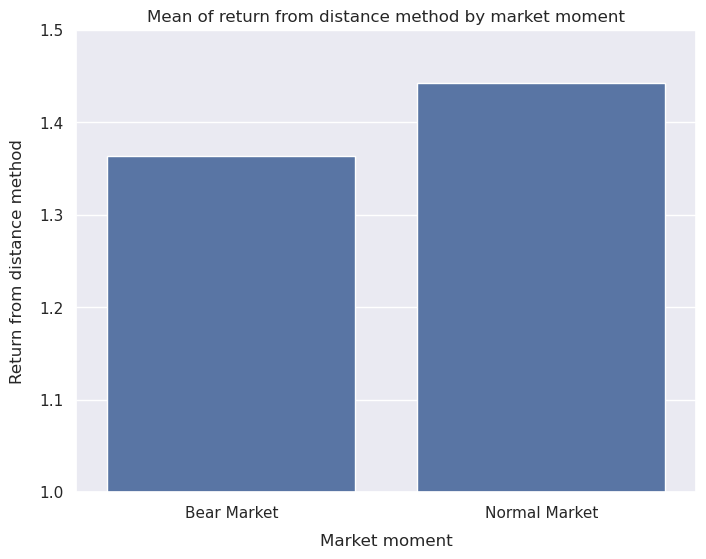

In [58]:
# Group média de retorno no semestre pelo tipo de mercado no semestre

comparison_markets = return_by_market.groupby('Market Type')['Return'].mean().to_frame().reset_index()
comparison_markets

# Boxplot style
sns.set_theme(style='darkgrid')
fig = plt.subplots(figsize=(8, 6))

# Plot data
ax = sns.barplot(comparison_markets, x='Market Type', y='Return')

ax.set_title('Mean of return from distance method by market moment')
ax.set_xlabel('Market moment', labelpad=10)
ax.set_ylabel('Return from distance method', labelpad=10)
ax.set_ylim(1, 1.5)

plt.savefig('./assets/hartford_bear_markets.png', bbox_inches='tight', pad_inches=0.2);